# 17634 Applied Machine Learning - HW3 - Amazon Review Clustering

Author: Yi-Hsueh Yang

In [1]:
import gzip 
import json
import random
import pandas as pd
import numpy as np
import gensim
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer, PorterStemmer
import string
import warnings 

#warnings.filterwarnings("ignore")

## Read in gzip file

In [2]:
path = 'Home_and_Kitchen.json.gz' 
path2 = 'meta_Home_and_Kitchen.json.gz'

In [3]:
# Define the percentage of data to downsample to
downsample_pct = 0.1

# Open the gzip file for reading
with gzip.open(path, 'rt') as f:
    downsampled_data = []

    for line in f:
        random_num = random.uniform(0, 1)
        if random_num < downsample_pct:
            load = json.loads(line)
            downsampled_data.append(load)

In [4]:
df = pd.DataFrame(downsampled_data)
print(df.shape)
df.head(3)

(2193953, 12)


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5.0,3,False,"01 23, 2010",A3T2DUQAOSS5JW,0681795107,S. Scales,This mug comes in a variety of colors most of ...,Best travel mug ever,1264204800,NaN,NaN
1,4.0,NaN,True,"03 22, 2013",A1CV69KIB30WW3,0681795107,PhilaSanctuary,"right size, attractive, keeps it hot, fairly e...","right size, keeps it hot",1363910400,{'Color:': ' Red'},NaN
2,5.0,NaN,True,"04 6, 2012",AO84V2TFRX9OB,0681795107,Meddybempster,"These mugs do what they are designed to do, i....",Keeps your drinks hot or cold for hours,1333670400,{'Color:': ' Brushed Stainless'},NaN


## Preprocessing

In [5]:
import nltk
from nltk.tokenize import word_tokenize
import spacy
import re

In [6]:
df.drop(columns=['verified','reviewTime','reviewerID','summary', 'vote', 'reviewerName','style','image', 'unixReviewTime'], inplace=True)
df.head()

,overall,asin,reviewText
0,5.0,0681795107,This mug comes in a variety of colors most of ...
1,4.0,0681795107,"right size, attractive, keeps it hot, fairly e..."
2,5.0,0681795107,"These mugs do what they are designed to do, i...."
3,4.0,0681795107,Like that this cup is stainless inside and out...
4,5.0,0768205921,Easy to use. Especially like the gears that m...


In [7]:
df = df.dropna(subset='reviewText')

In [8]:
number_pattern = re.compile(r'[^a-zA-Z\s\'-]')

# remove numbers and convert to lower case for the sentence column
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(number_pattern, '', str(x).lower()) if x is not None else '')

In [9]:
def preprocess_text_lemmatize(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers and punctuation
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the tokens back into a string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

In [10]:
def preprocess_text_stemming(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    preprocessed_stemmed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_stemmed_text

In [11]:
df['preprocessed_text_lemmatized'] = df['reviewText'].apply(preprocess_text_lemmatize)
df['preprocessed_text_stemmed'] = df['reviewText'].apply(preprocess_text_stemming)

In [12]:
import gensim.corpora as corpora

df['tokenized_text'] = df['preprocessed_text_lemmatized'].apply(lambda x: x.split())

# Create a corpus from a list of texts.
dictionary = corpora.Dictionary(df['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]

### LDA Model Training

In [13]:
from gensim.models import CoherenceModel
topic_n = 10

lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=topic_n, passes=10, workers=4, dtype=np.float64)

# Compute coherence score
coherence_model = CoherenceModel(model=lda, texts=df['tokenized_text'], dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print("Coherence Score: ", coherence)

for ix in range(topic_n):
  top10 = np.argsort(lda.get_topics()[ix])[-10:]
  print(f'{ix}:  {" ".join([dictionary[index] for index in top10])}') 

Coherence Score:  0.5355531979507928
0:  loved nice great cute look perfect gift beautiful color love
1:  tea keep use hot bottle glass lid coffee cup water
2:  star mattress box item quality received review one would product
3:  size container perfect food great love bowl easy make use
4:  dish hand cut clean well like handle use pan knife
5:  would chair cover like together sheet put fit bed pillow
6:  last used old day ive month bought time year one
7:  like use light get battery air vacuum fan unit work
8:  clock towel wall small nice curtain light bag like look
9:  easy look nice well price work product quality good great


In [14]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(lda, corpus, dictionary)

pyLDAvis.display(vis)

/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [15]:
df['tokenized_text'] = df['preprocessed_text_stemmed'].apply(lambda x: x.split())

dictionary = corpora.Dictionary(df['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]

In [16]:
topic_n = 10

lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=topic_n, passes=10, workers=4, dtype=np.float64)

coherence_model = CoherenceModel(model=lda, texts=df['tokenized_text'], dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print("Coherence Score: ", coherence)

for ix in range(topic_n):
  top10 = np.argsort(lda.get_topics()[ix])[-10:]
  print(f'{ix}:  {" ".join([dictionary[index] for index in top10])}') 

Process SpawnPoolWorker-25:
Process SpawnPoolWorker-24:
Process SpawnPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/Users/alexy

KeyboardInterrupt: 

In [ ]:
vis = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## Improvements

### Filter the record based on their ratings

<AxesSubplot: xlabel='overall', ylabel='Count'>

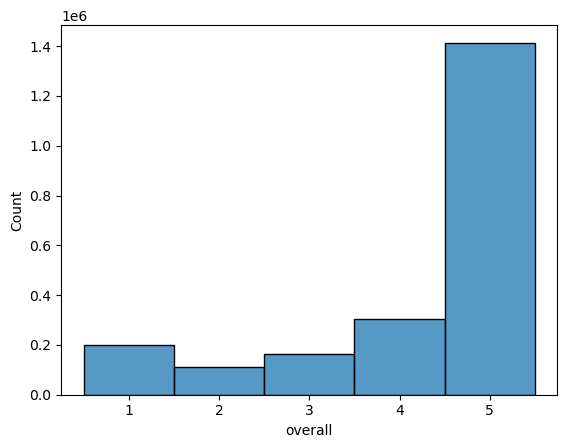

In [ ]:
import seaborn as sns

df['overall'] = df['overall'].astype(int).astype('category')

sns.histplot(data=df, x='overall')

In [ ]:
# Taking only records with the rating less than 2.
less_than_3 = df[(df['overall'] == 1) | (df['overall'] == 2)]
less_than_3.shape

(312223, 6)

### Add in more stop words from the observations of the previous topic selection


In [ ]:
def preprocess2_lemmatization(text):
    text = text.lower()
    
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = word_tokenize(text)
    
    # Add in more stopwords
    stop_words = set(stopwords.words('english'))
    new_stopwords = ['get', 'would', 'use', 'one', 'used', 'im']
    stop_words.update(new_stopwords)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text
    
less_than_3['preprocessed_text_lemmatized'] = less_than_3['reviewText'].apply(preprocess2_lemmatization)
less_than_3['tokenized_text'] = less_than_3['preprocessed_text_lemmatized'].apply(lambda x: x.split())

/var/folders/zs/j91wn79j45lccf78212k1pp80000gn/T/ipykernel_26959/595894903.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_than_3['preprocessed_text_lemmatized'] = less_than_3['reviewText'].apply(preprocess2_lemmatization)
/var/folders/zs/j91wn79j45lccf78212k1pp80000gn/T/ipykernel_26959/595894903.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_than_3['tokenized_text'] = less_than_3['preprocessed_text_lemmatized'].apply(lambda x: x.split())


In [ ]:
dictionary = corpora.Dictionary(less_than_3['tokenized_text'])
corpus = [dictionary.doc2bow(text) for text in less_than_3['tokenized_text']]

### build LDA again

In [ ]:
lda = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=topic_n, passes=10, workers=4, dtype=np.float64)

coherence_model = CoherenceModel(model=lda, texts=less_than_3['tokenized_text'], dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print("Coherence Score: ", coherence)

for ix in range(topic_n):
  top10 = np.argsort(lda.get_topics()[ix])[-10:]
  print(f'{ix}:  {" ".join([dictionary[index] for index in top10])}') 

Coherence Score:  0.5374005425845021
0:  knife feel thin mattress bag like bed quality sheet pillow
1:  expected size quality disappointed small cheap color picture like look
2:  mug food fit plastic top bottle glass handle pan lid
3:  time make maker leak hot filter machine cup coffee water
4:  last worked first bought time working week broke year month
5:  came arrived received back amazon box broken item return product
6:  buy battery doesnt clock light dont waste time money work
7:  hold apart back screw fit chair made put together piece
8:  still even soap product away rust clean stick like smell
9:  make temperature also heat work much room fan air unit


In [ ]:
vis = gensimvis.prepare(lda, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### Extract Metadata and feature engineering

In [ ]:
with gzip.open(path2, 'rt') as f:
    downsampled_data = []

    for line in f:
        random_num = random.uniform(0, 1)
        if random_num < downsample_pct:
            load = json.loads(line)
            downsampled_data.append(load)

meta = pd.DataFrame(downsampled_data)
print(meta.shape)
meta.head(3)

NameError: name 'gzip' is not defined

In [ ]:
meta = meta[['category', 'asin']]
meta.head()

,category,asin
0,"[Home & Kitchen, Home Dcor, Candles & Holders,...",0326591516
1,"[Home & Kitchen, Wall Art, Posters & Prints]",0756045142
2,"[Home & Kitchen, Wall Art, Posters & Prints]",0756044251
3,"[Home & Kitchen, Home Dcor, Home Dcor Accents,...",0830771174
4,"[Home & Kitchen, Home Dcor]",0984669701


In [ ]:
merged_data = pd.merge(meta, less_than_3, on='asin')
print(merged_data.shape)

(33326, 7)


In [ ]:
merged_data = merged_data.explode('category').reset_index(drop=True)
print(merged_data.shape)
merged_data.head()

(145230, 7)


,category,asin,overall,reviewText,preprocessed_text_lemmatized,preprocessed_text_stemmed,tokenized_text
0,Home & Kitchen,1890560243,2,there are not enough word combinations to trul...,enough word combination truly practice french,enough word combin truli practic french,"[enough, word, combination, truly, practice, f..."
1,Kitchen & Dining,1890560243,2,there are not enough word combinations to trul...,enough word combination truly practice french,enough word combin truli practic french,"[enough, word, combination, truly, practice, f..."
2,Kitchen Utensils & Gadgets,1890560243,2,there are not enough word combinations to trul...,enough word combination truly practice french,enough word combin truli practic french,"[enough, word, combination, truly, practice, f..."
3,Kitchen Accessories,1890560243,2,there are not enough word combinations to trul...,enough word combination truly practice french,enough word combin truli practic french,"[enough, word, combination, truly, practice, f..."
4,Refrigerator Magnets,1890560243,2,there are not enough word combinations to trul...,enough word combination truly practice french,enough word combin truli practic french,"[enough, word, combination, truly, practice, f..."


In [ ]:
merged_data['tokenized_text'] = [' '.join(tokens) for tokens in merged_data['tokenized_text']]

In [ ]:
# Extract the tokenized_text and category columns from dataframe
tokenized_text = merged_data['tokenized_text']
category = merged_data['category']
docs_with_meta = [(doc.split(), meta_data) for doc, meta_data in zip(tokenized_text, category)]

# Create a gensim dictionary object
dictionary = corpora.Dictionary(tokenized_text)

# Create a corpus of BoW vectors with metadata
corpus = []
for i, doc in enumerate(tokenized_text):
    bow_vector = dictionary.doc2bow(doc)
    corpus.append((bow_vector, {'metadata': category[i]}))

In [ ]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=10, workers=4, dtype=np.float64)

coherence_model = CoherenceModel(model=lda_model, texts=merged_data['tokenized_text'], dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print("Coherence Score: ", coherence)

for ix in range(topic_n):
  top10 = np.argsort(lda.get_topics()[ix])[-10:]
  print(f'{ix}:  {" ".join([dictionary[index] for index in top10])}') 

Process SpawnPoolWorker-70:
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 346, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 767, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamodel.py", line 698, in inference
    ids = [int(idx) for idx, _ in doc]
  File "/Users/alexyang/opt/ana

KeyboardInterrupt: 

In [17]:
import pickle 

with open('lda_model.pkl', 'wb') as f:
    pickle.dump(lda, f)

Process SpawnPoolWorker-37:
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
EOFError: Ran out of input
Process SpawnPoolWorker-38:
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/alexyang/opt/a

Process SpawnPoolWorker-40:
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 109, in worker
    initializer(*initargs)
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/site-packages/gensim/models/ldamulticore.py", line 341, in worker_e_step
    chunk_no, chunk, w_state = input_queue.get()
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
EOFError: Ran out of input
Process SpawnPoolWorker-41:
Traceback (most recent call last):
  File "/Users/alexyang/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/alexyang/opt/a